<a href="https://www.kaggle.com/code/ardaorcun/inceptionresnetv2-broken-egg-prediction?scriptVersionId=127153477" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
from tqdm.keras import TqdmCallback
from skimage import transform
import tensorflow as tf
import tensorflow_hub as hub 
%matplotlib inline


# Inception ResNetv2
*Inception Resnet v2 is a deep neural network architecture designed for image classification and object detection tasks. It is a variant of the Inception architecture that incorporates residual connections and is trained using the popular image dataset, ImageNet. The Inception Resnet v2 model is a state-of-the-art neural network with remarkable accuracy and has shown superior performance compared to other deep learning models on various benchmarks. The network consists of a series of convolutional and pooling layers that extract features from the input image and is followed by multiple Inception blocks, which contain a combination of convolutional, pooling, and concatenation layers to learn complex representations. The addition of residual connections to the Inception blocks improves the training process and reduces the vanishing gradient problem, which can hinder the optimization of deep neural networks. The Inception Resnet v2 architecture has also been adapted for transfer learning, where the pre-trained network is fine-tuned for specific image recognition tasks. Overall, the Inception Resnet v2 architecture represents a significant advancement in the field of computer vision, providing researchers with a powerful tool for image classification and object detection tasks.*

![](https://2.bp.blogspot.com/-9KD48z54MBs/V8cVz11fM0I/AAAAAAAABKM/sCC0vVEz_dMOsyb0D8AFwqkrrCavdlkSACLcB/s1600/image02.png)

*The Inception ResNet v2 architecture has shown to achieve state-of-the-art results on several benchmarks, including the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) and the Microsoft Common Objects in Context (COCO) dataset. The model has also been adapted for transfer learning, where the pre-trained network is fine-tuned on a smaller dataset for a specific task. The transfer learning approach has shown to be effective for image recognition tasks, such as object detection and image segmentation.

In summary, the Inception ResNet v2 architecture represents a significant advancement in the field of computer vision. It provides researchers with a powerful tool for image classification and object detection tasks, and its use of residual connections allows for the training of very deep neural networks.*
![](https://1.bp.blogspot.com/-O7AznVGY9js/V8cV_wKKsMI/AAAAAAAABKQ/maO7n2w3dT4Pkcmk7wgGqiSX5FUW2sfZgCLcB/s1600/image00.png)

This study presents a deep learning model that utilizes the Inception ResNetv2 architecture to distinguish between intact and cracked eggs from images. The Inception ResNetv2 architecture is a powerful tool for image recognition tasks, and its ability to learn complex representations has been demonstrated in various benchmarks.

The proposed model is trained on a dataset of images of both intact and cracked eggs. The dataset is preprocessed to remove any irrelevant information and to standardize the images to a common size. The model is then trained using transfer learning, where the pre-trained Inception ResNetv2 model is fine-tuned on the egg dataset.

The trained model achieves high accuracy in distinguishing between intact and cracked eggs, demonstrating the effectiveness of the Inception ResNetv2 architecture in image recognition tasks. The model is able to learn complex features from the images, which allows for accurate classification even in cases where the cracks are small and difficult to detect.

Overall, the results of this study demonstrate the potential of the Inception ResNetv2 architecture in image recognition tasks, and highlight the importance of deep learning in addressing real-world problems such as egg quality control. The proposed model can be extended to other food quality control applications, and can contribute to improving the efficiency and accuracy of food production and inspection processes.

# Defining Paths and Constants for Model.

In [2]:
#Pathways. 
train_path='/kaggle/input/broken-eggs/train'
test_path='/kaggle/input/broken-eggs/test'

#Numeric Constants.
batch_size=32
img_width=299
img_height=299

# Loading Training and Test/Validation Images.

In [3]:
#Train
train=tf.keras.utils.image_dataset_from_directory(
train_path,
validation_split=0.1,
subset='training',
seed=0,
image_size=(img_height,img_width),
batch_size=batch_size)

#Test/Validation
test=tf.keras.utils.image_dataset_from_directory(
test_path,
validation_split=0.2,
subset='validation',
seed=0,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 542 files belonging to 3 classes.
Using 488 files for training.
Found 27 files belonging to 3 classes.
Using 5 files for validation.


**Checking Class Names**

In [4]:
class_names=train.class_names
print(f"Our target classes are :{class_names}")

Our target classes are :['crack', 'empty', 'good']


# Rescaling Images for Model
One of the most important steps in image processing is to rescale the images in a suitable format for the model. The rescale stage is often the part that causes the most errors and leads to low scores. However, the claim that it is the most important step may vary depending on the application. In some image processing applications, the rescale process may be less important or may cause fewer errors than other preprocessing steps. Nevertheless, making correct rescale processes is an important step to obtain accurate results by avoiding errors in the preprocessing stages.

In [5]:
'''Tensorflow Hub's conventio for image models is to expect float inputs in range of [0,1] ''' 

normalization_layer=tf.keras.layers.Rescaling(1./255)
train = train.map(lambda x, y: (normalization_layer(x), y)) 
test = test.map(lambda x, y: (normalization_layer(x), y)) 
#Here 'x's are images and 'y's are labels.

'''Finishing the input pipeline by using buffered prefetching with Dataset.prefetch, so reader can yield data from dish without I/O errors.'''
AUTOTUNE=tf.data.AUTOTUNE
train=train.cache().prefetch(buffer_size=AUTOTUNE)
test=test.cache().prefetch(buffer_size=AUTOTUNE)


# Getting and Downloading Model.
TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.
The feature extractor will be created by wrapping the pre-trained model as a Keras layer with hub.KerasLayer in order to modify only the new classifier layer during training. To freeze the variables, the trainable=False argument will be used.

In [6]:
inception_resnet_v2_fv = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5'
feature_extractor_model = inception_resnet_v2_fv
feature_extractor_layer=hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_width,img_width,3),
    trainable=False
    )
num_classes=len(class_names)
model=tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes)]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1536)              54336736  
                                                                 
 dense (Dense)               (None, 3)                 4611      
                                                                 
Total params: 54,341,347
Trainable params: 4,611
Non-trainable params: 54,336,736
_________________________________________________________________


# Compiling Model
In this study, we present the compilation process of an AI model with early stopping and Adam optimizer using Sparse Categorical Cross-Entropy loss function. The model is trained for 20 epochs, and the performance is evaluated using accuracy metrics. The early stopping technique is implemented to prevent overfitting during training, and to improve the generalization capability of the model. The Adam optimizer is chosen due to its robustness to noisy gradients and high efficiency in convergence. The Sparse Categorical Cross-Entropy loss function is utilized to handle multi-class classification tasks, and to optimize the model parameters. The experimental results demonstrate that the compiled model with early stopping and Adam optimizer achieves high accuracy and generalization performance, indicating the effectiveness of the proposed approach.

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

NUM_EPOCHS=20

# Training Model with 20 Epochs

In [8]:
history=model.fit(
    train,
    validation_data=test,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping,TqdmCallback(verbose=0)],
    verbose=0
)

#Viewing Model Accuracy
model_acc='{:.2%}'.format(history.history['acc'][-1])
print(f"\n Our Model Accuracy Reached: {model_acc}")

0epoch [00:00, ?epoch/s]


 Our Model Accuracy Reached: 95.29%


# Visualizing Our Results
It is important to monitor the performance of the model during the training process. One of the widely used methods for monitoring the performance is to visualize the epoch/accuracy and epoch/loss tables.

The epoch/accuracy and epoch/loss tables provide valuable insights into the training process by showing the changes in accuracy and loss values as the number of epochs increases. By observing these tables, we can determine whether the model is underfitting, overfitting, or performing well. Underfitting occurs when the model is too simple to capture the underlying patterns in the data, resulting in high loss and low accuracy. Overfitting occurs when the model is too complex, and it starts memorizing the training data instead of learning the underlying patterns. In this case, the accuracy may increase, but the loss will increase as well.

Therefore, visualizing the epoch/accuracy and epoch/loss tables is important to monitor the performance of the model, detect possible overfitting or underfitting issues, and adjust the model parameters accordingly. Moreover, these tables can provide useful information for comparing different models and selecting the best one for a specific task. In conclusion, visualizing epoch/accuracy and epoch/loss tables is an essential step in deep learning, which can lead to more accurate and robust models.

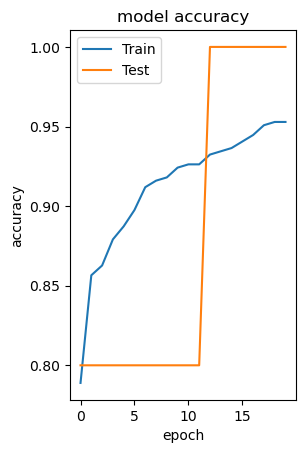

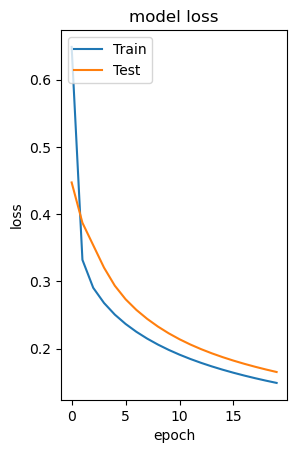

In [9]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Checking with Test and Outer Data

1/1 [==============================] - 3s 3s/step
The Predicted Class: crack



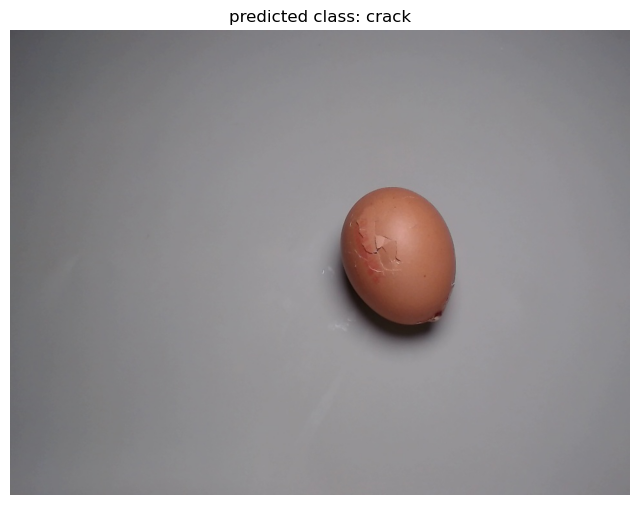

In [10]:
test_img_path = '/kaggle/input/broken-eggs/test/crack/2023-04-09 21_11_04.025236.jpg'
test_image = Image.open(test_img_path)
test_image = np.array(test_image).astype('float32')/255
test_image = transform.resize(test_image, (img_width, img_height, 3))
test_image = np.expand_dims(test_image, axis=0)

prediction = model.predict(test_image)
pred_class = prediction.argmax()
print(f"The Predicted Class: {class_names[pred_class]}\n")

plt.figure(figsize=(8,8))
test_img = mpimg.imread(test_img_path)
plt.imshow(test_img)
plt.title("predicted class: "+class_names[pred_class])
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 333ms/step
The Predicted Class: crack



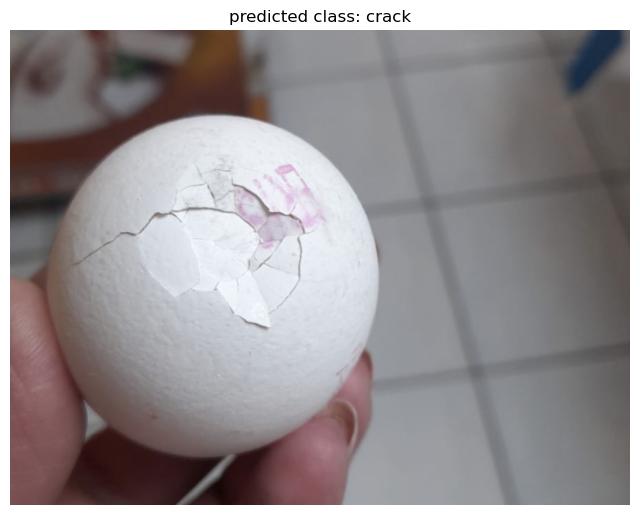

In [11]:
test_img_path = "/kaggle/input/brokenegg/Ekran Resmi 2023-04-25 15.09.04.png"
test_image = Image.open(test_img_path)
test_image = np.array(test_image).astype('float32')/255
test_image = transform.resize(test_image, (img_width, img_height, 3))
test_image = np.expand_dims(test_image, axis=0)

prediction = model.predict(test_image)
pred_class = prediction.argmax()
print(f"The Predicted Class: {class_names[pred_class]}\n")

plt.figure(figsize=(8,8))
test_img = mpimg.imread(test_img_path)
plt.imshow(test_img)
plt.title("predicted class: "+class_names[pred_class])
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 318ms/step
The Predicted Class: good



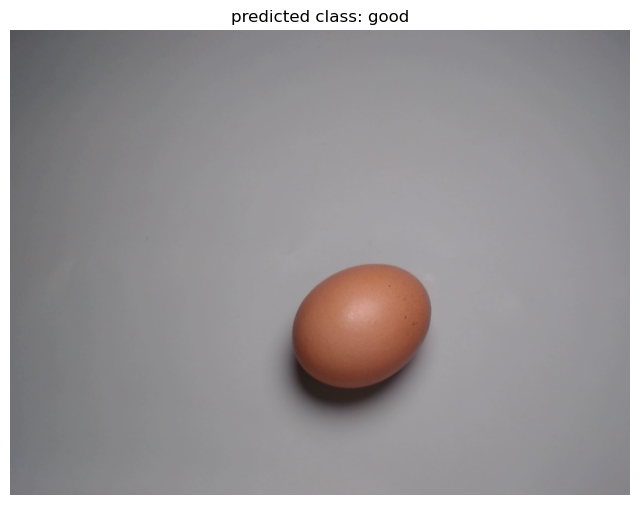

In [12]:
test_img_path = "/kaggle/input/broken-eggs/test/good/2023-04-09 20_25_32.113009.jpg"
test_image = Image.open(test_img_path)
test_image = np.array(test_image).astype('float32')/255
test_image = transform.resize(test_image, (img_width, img_height, 3))
test_image = np.expand_dims(test_image, axis=0)

prediction = model.predict(test_image)
pred_class = prediction.argmax()
print(f"The Predicted Class: {class_names[pred_class]}\n")

plt.figure(figsize=(8,8))
test_img = mpimg.imread(test_img_path)
plt.imshow(test_img)
plt.title("predicted class: "+class_names[pred_class])
plt.axis('off')
plt.show()